## Imports

In [16]:
from src.tokenizer import Tokenizer, normalize_text
from src.vis import plot_attention

from typing import Tuple
import random
import numpy as np
import pytest

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import evaluate

import matplotlib.pyplot as plt
import jupyter_black

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

jupyter_black.load()
%matplotlib inline

## Dataset

In [33]:
src_tok: Tokenizer = torch.load("data/src_tok.pt")
tgt_tok: Tokenizer = torch.load("data/tgt_tok.pt")
vocab_size = src_tok.vocab_size
pad_token_ix = src_tok.wtoi[src_tok.pad_token]
print(f"Vocab size: {vocab_size}")
print(f"Pad token index: {pad_token_ix}")

Vocab size: 512
Pad token index: 0


In [3]:
train_dl: DataLoader = torch.load("data/train_dl.pt")
val_dl: DataLoader = torch.load("data/val_dl.pt")
test_dl: DataLoader = torch.load("data/test_dl.pt")
tiny_train_dl: DataLoader = torch.load("data/tiny_train_dl.pt")

## Model Architecture

The Bahdanau Attention Model is structured as follows:
- Bidirectional Encoder RNN
- Unidirectional Decoder RNN with Bahdanau (Additive) Attention mechanism

### Encoder

#### Architecture

In [10]:
class AttnEncoder(nn.Module):
    def __init__(
        self,
        input_size: int,
        emb_size: int,
        hidden_size: int,
    ):
        super().__init__()
        self.emb = nn.Embedding(input_size, emb_size)  # (V, D)
        self.rnn = nn.GRU(
            emb_size,
            hidden_size,
            batch_first=True,
            bidirectional=True,
        )

    def forward(self, X) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        :param X: (N, T) where N is the batch size and T is the sequence length
        :return out: (N, T, 2H) where H is the hidden size and 2 is for bidirectional
        :return hidden: (L, N, 2H) where L is the number of layers
        """
        emb = self.emb(X)  # (N, T, D)
        out, hidden = self.rnn(emb)  # (N, T, 2H), (2L, N, H)
        # Hidden states need to be concatenated on the hidden state axis
        # AKA, go from (2L, N, H) -> (L, N, 2H)
        hidden = torch.cat((hidden[:1], hidden[1:]), dim=-1)  # (L, N, 2H)
        return out, hidden

#### Testing the Encoder

In [11]:
D = H = 10  # Embedding and hidden state dimensions
X, _ = next(iter(tiny_train_dl))  # Unpack just the first source batch (N, T)

"""Testing the Encoder"""

enc = AttnEncoder(
    input_size=vocab_size,
    emb_size=D,
    hidden_size=H,
).to(device)
out, hidden = enc(X)

print(out.shape, out.shape == (*X.shape, 2 * H))  # (N, T, 2H)
print(hidden.shape, hidden.shape == (1, X.shape[0], 2 * H))  # (L, N, 2H)

torch.Size([5, 12, 20]) True
torch.Size([1, 5, 20]) True


### Bahdanau (Additive) Attention

#### Architecture

In [39]:
class AdditiveAttention(nn.Module):
    def __init__(
        self,
        query_size: int,
        key_size: int,
        hidden_size: int,
    ):
        super().__init__()
        self.Q = nn.Linear(query_size, hidden_size, bias=False)  # (Dq, H)
        self.K = nn.Linear(key_size, hidden_size, bias=False)  # (Dk, H)
        self.V = nn.Linear(hidden_size, 1)  # (H, 1)

        self.apply(self._init_weights)

    def _init_weights(self, module: nn.Module):
        # Initialize weights
        for name, param in module.named_parameters():
            if name.startswith("V"):
                nn.init.zeros_(param.data)
            else:
                nn.init.normal_(param.data, mean=0.0, std=0.001**2)

    def forward(self, queries, keys, values, mask=None):
        """
        i = sequence word index (from decoder target sentence, aka queries)
        j = annotation index (from encoder source sentence, aka keys and values)

        e_{ij} = a(s_{i-1}, h_j) = v_a.T * tanh(W_a*s_{i-1} + U_a*h_j)
        alpha_{ij} = softmax(e_{ij})
        c_i = sum(alpha_{ij}*h_{j}) from j=1 to Tx

        queries: (N, M, Dq)
        keys: (N, T, Dk)
        values: (N, T, Dv)
        """

        def a(s, h):
            # Compute query aka W_a * s_{i-1} and key aka U_a * h_j
            query = self.Q(s)  # (N, M, Dq) @ (Dq, H) -> (N, M, H)
            key = self.K(h)  # (N, T, Dk) @ (Dk, HJ -> (N, T, H)

            # Now we need to add and take the tanh of them
            query_key = query.unsqueeze(2) + key.unsqueeze(1)  # (N, M, T, H)
            return self.V(torch.tanh(query_key)).squeeze(
                -1
            )  # (N, M, T, H) @ (H, 1) -> (N, M, T)

        # Calculate e_ij
        e_ij = a(queries, keys)

        # Now we calculate the attention weights alpha_{ij}
        if mask is not None:
            e_ij = e_ij.masked_fill(mask == 0, float("-inf"))
        self.attn_weights = F.softmax(e_ij, dim=-1)  # (N, M, T)

        # To calculate the full context vector c_i, we matmul the attention weights
        # with the annotations h_j aka the values
        context = self.attn_weights @ values  # (N, M, T) @ (N, T, Dv) -> N, M, Dv
        return context

#### Testing Additive Attention

In [43]:
D = H = 10  # Embedding and hidden state dimensions
X, Y = next(iter(tiny_train_dl))  # Unpack just the first source batch (N, T)
enc_mask = (X != pad_token_ix).type(torch.long).unsqueeze(1)  # (N, 1, T)

"""Testing the Encoder"""

enc = AttnEncoder(
    input_size=vocab_size,
    emb_size=D,
    hidden_size=H,
).to(device)
out, hidden = enc(X)

print(out.shape, out.shape == (*X.shape, 2 * H))  # (N, T, 2H)
print(hidden.shape, hidden.shape == (1, X.shape[0], 2 * H))  # (L, N, 2H)

"""Testing Additive Attention"""

# T = Y.shape[1]
T = 1
emb_ = nn.Embedding(vocab_size, D).to(device)
dec_in = emb_(Y[:, :T])  # (N, 1, D)


attn = AdditiveAttention(
    query_size=H,
    key_size=2 * H,
    hidden_size=H,
).to(device)

context = attn(dec_in, out, out, mask=enc_mask)
print(context.shape, context.shape == (X.shape[0], T, 2 * H))  # (N, 1, 2H)

torch.Size([5, 12, 20]) True
torch.Size([1, 5, 20]) True
torch.Size([5, 1, 20]) True


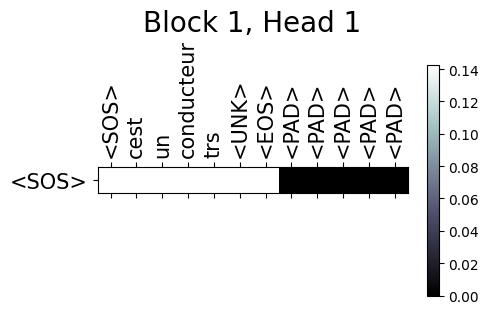

In [45]:
ix = 2
src_sent = src_tok.untokenize(
    X[ix].detach().tolist(), remove_padding_tokens=False
).split()
tgt_sent = tgt_tok.untokenize(
    Y[ix].detach().tolist(), remove_padding_tokens=False
).split()[:T]
plot_attention(sentence=src_sent, translation=tgt_sent, attention=attn.attn_weights[ix])

### Decoder

#### Architecture

In [42]:
class AttnDecoder(nn.Module):
    def __init__(
        self,
        attention: AdditiveAttention,
        output_size: int,
        emb_size: int,
        hidden_size: int,
    ):
        super().__init__()
        self.output_size = output_size
        self.attn = attention
        self.emb = nn.Embedding(output_size, emb_size)
        self.rnn = nn.GRU(
            emb_size + hidden_size,  # D+2H
            hidden_size,
            batch_first=True,
        )
        self.lin = nn.Linear(emb_size + 2 * hidden_size, output_size)  # D+3H

    def forward(self, Y, enc_out, hidden, mask=None):
        """
        :param Y: (N, 1) target samples for some time step t
        :param enc_out: (N, T, H) encoder hidden state
        :param hidden: (1, N, H) decoder hidden state
        - the hidden parameter is initially the final encoder hidden state
        :param mask: (N, 1, T) mask for the encoder output
        :return out: (N, 1, V) output for time step t
        """
        emb = self.emb(Y)  # (N, 1, D)
        query_in = hidden.permute(1, 0, 2)  # (N, 1, H)
        context = self.attn.forward(
            queries=query_in,
            keys=enc_out,
            values=enc_out,
            mask=mask,
        )  # (N, 1, H)

        # Since it's complicated to open up the GRU and add the context vector
        # in its computations, we can just concatenate the context vector to
        # the embedded target input
        emb_and_context = torch.cat((emb, context), dim=-1)  # (N, 1, D+H)

        # Get the RNN output and final hidden state
        dec_out, hidden = self.rnn.forward(
            emb_and_context, hidden
        )  # (N, 1, H), (1, N, H)
        assert (dec_out == hidden.permute(1, 0, 2)).all()

        # Now, concatenate the decoder output s_{i-1}, the embedding Ey_{i-1} and
        # the context vector c_i, and pass them through a linear layer
        lin_in = torch.cat((emb_and_context, dec_out), dim=-1)  # (N, 1, D+2H)
        out = self.lin(lin_in)  # (N, 1, V)
        return out, hidden, self.attn.attn_weights  # (N, 1, V), (1, N, H), (N, 1, T)

#### Testing the Decoder

In [56]:
D = H = 10  # Embedding and hidden state dimensions
X, Y = next(iter(tiny_train_dl))  # Unpack just the first source batch (N, T)
enc_mask = (X != pad_token_ix).type(torch.long).unsqueeze(1)  # (N, 1, T)

"""Testing the Encoder"""

enc = AttnEncoder(
    input_size=vocab_size,
    emb_size=D,
    hidden_size=H // 2,
).to(device)
out, hidden = enc(X)

print(out.shape, out.shape == (*X.shape, H))  # (N, T, 2H)
print(hidden.shape, hidden.shape == (1, X.shape[0], H))  # (L, N, 2H)

"""Testing the Decoder"""

attn = AdditiveAttention(
    query_size=H,
    key_size=H,
    hidden_size=H,
).to(device)

dec = AttnDecoder(
    attention=attn,
    output_size=vocab_size,
    emb_size=D,
    hidden_size=H,
).to(device)

T = 1
out, hidden, attn_weights = dec(Y[:, :T], out, hidden, mask=enc_mask)
print(out.shape, out.shape == (X.shape[0], 1, vocab_size))  # (N, 1, V)
print(hidden.shape, hidden.shape == (1, X.shape[0], H))  # (1, N, H)
print(
    attn_weights.shape, attn_weights.shape == (X.shape[0], 1, X.shape[1])
)  # (N, 1, T)

torch.Size([5, 12, 10]) True
torch.Size([1, 5, 10]) True
torch.Size([5, 1, 512]) True
torch.Size([1, 5, 10]) True
torch.Size([5, 1, 12]) True


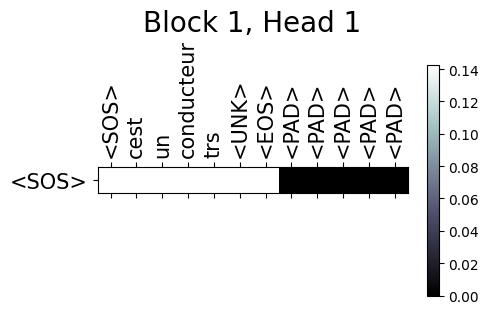

In [57]:
ix = 2
src_sent = src_tok.untokenize(
    X[ix].detach().tolist(), remove_padding_tokens=False
).split()
tgt_sent = tgt_tok.untokenize(
    Y[ix].detach().tolist(), remove_padding_tokens=False
).split()[:T]
plot_attention(sentence=src_sent, translation=tgt_sent, attention=attn_weights[ix])

### Attention Seq2Seq Network

#### Architecture

In [71]:
class AttnSeq2Seq(nn.Module):
    def __init__(
        self,
        encoder: AttnEncoder,
        decoder: AttnDecoder,
    ):
        super().__init__()
        self.enc = encoder
        self.dec = decoder
        self.apply(self._init_weights)

    def _init_weights(self, module: nn.Module):
        # Initialize uniform weights between -0.08 and 0.08
        # for the model
        for _, param in module.named_parameters():
            nn.init.uniform_(param.data, -0.08, 0.08)

    def forward(
        self,
        source: torch.tensor,
        target: torch.tensor,
        teacher_force_ratio: float = 0.0,
        mask: torch.tensor = None,
    ):
        """
        :param source: (N, T) where N is the batch size and T is the sequence length
        :param target: (N, T)
        :return: (N, T, V) predictions for each token in the target sequence
        """
        N, T = source.shape
        V = self.dec.output_size
        # Encoder step
        enc_out, hidden = self.enc.forward(source)  # (N, T, 2H), (1, N, 2H)
        # Decoder step
        self.attn_weights = torch.zeros(N, T, T, device=source.device)  # (N, T, T)
        outputs = torch.zeros(N, T, V, device=source.device)  # (N, T, V)
        target_t = target[:, :1]  # (N, 1) initial decoder input token

        # We loop here as to let the function decide which input to use in each proceeding
        # RNN cell
        for t in range(1, T):
            dec_out, hidden, attn = self.dec.forward(
                Y=target_t,
                enc_out=enc_out,
                hidden=hidden,
                mask=mask,
            )  # (N, 1, V), (1, N, 2H)
            # Set attention output into total attention
            self.attn_weights[:, t : t + 1, :] = attn
            # Set decoder output into total outputs
            outputs[:, t : t + 1] = dec_out  # (N, 1, V) -> (N, T, V)

            # Set up next input to decoder
            teacher_force = random.random() < teacher_force_ratio
            target_t = target[:, t : t + 1] if teacher_force else dec_out.argmax(-1)

        return outputs

#### Testing the Attention Seq2Seq Network

In [72]:
D = H = 10  # Embedding and hidden state dimensions
X, Y = next(iter(tiny_train_dl))  # Unpack just the first source batch (N, T)
enc_mask = (X != pad_token_ix).type(torch.long).unsqueeze(1)  # (N, 1, T)

enc = AttnEncoder(
    input_size=vocab_size,
    emb_size=D,
    hidden_size=H // 2,
)

attn = AdditiveAttention(
    query_size=H,
    key_size=H,
    hidden_size=H,
)

dec = AttnDecoder(
    attention=attn,
    output_size=vocab_size,
    emb_size=D,
    hidden_size=H,
)

model = AttnSeq2Seq(
    encoder=enc,
    decoder=dec,
).to(device)
out = model.forward(X, Y, teacher_force_ratio=0.0, mask=enc_mask)
print(out.shape, out.shape == (*Y.shape, vocab_size))  # (N, T, V)

torch.Size([5, 12, 512]) True


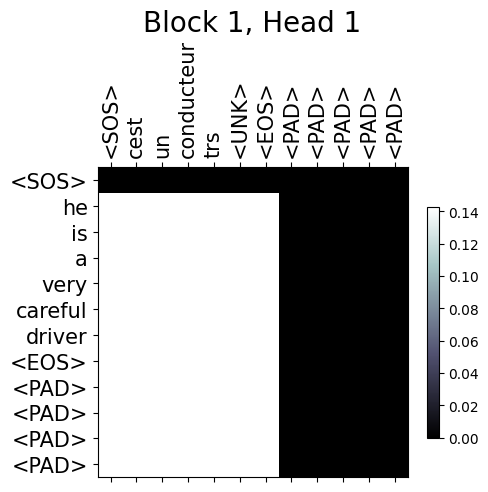

In [73]:
ix = 2
src_sent = src_tok.untokenize(
    X[ix].detach().tolist(), remove_padding_tokens=False
).split()
tgt_sent = tgt_tok.untokenize(
    Y[ix].detach().tolist(), remove_padding_tokens=False
).split()
plot_attention(
    sentence=src_sent, translation=tgt_sent, attention=model.attn_weights[ix]
)

## Training the Attention Seq2Seq Network

In [74]:
def model_forward(
    model,
    source,
    target,
    loss_fn,
    teacher_force_ratio,
):
    # Forward pass - grab the logits that we'll map
    # to probabilities in the loss calculation
    logits = model.forward(
        source=source,
        target=target,
        teacher_force_ratio=teacher_force_ratio,
    )  # (N, T, V)
    _, _, V = logits.shape
    # Fit the logits into 2 dimensions
    logits = logits[:, 1:].reshape(-1, V).to(device)  # (N*(T-1), V)
    target = target[:, 1:].reshape(-1)  # (N*(T-1),)

    # Loss calculation
    loss = loss_fn(logits, target)
    return loss

In [75]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optim,
    teacher_force_ratio: float = 0.5,
):
    # Iterate through one epoch-worth of data
    model.train()
    epoch_loss = 0
    # Iterate through the data loader
    for it, batch in enumerate(data_loader):
        optim.zero_grad()

        # Unpack the data loader
        # into source and target sequences
        xb, yb = batch  # (N, T), (N, T)

        # Forward pass - grab the logits that we'll map
        # to probabilities in the loss calculation
        loss = model_forward(model, xb, yb, loss_fn, teacher_force_ratio)
        epoch_loss += loss.item()

        # Backward pass
        loss.backward()

        # Optimization step
        optim.step()

    return epoch_loss / len(data_loader)

In [76]:
@torch.no_grad()
def evaluate_epoch(
    model,
    data_loader,
    loss_fn,
):
    model.eval()
    epoch_loss = 0
    # Iterate through all data in the data loader
    for batch in data_loader:
        # Unpack the data loader
        xb, yb = batch

        # Forward pass
        loss = model_forward(model, xb, yb, loss_fn, teacher_force_ratio=0.0)
        epoch_loss += loss.item()

    return epoch_loss / len(data_loader)

In [78]:
D, H, L = 256, 512, 2
lr = 1e-3

enc = AttnEncoder(vocab_size, D, H // 2)
attn = AdditiveAttention(H, H, H)
dec = AttnDecoder(attn, vocab_size, D, H)
model = AttnSeq2Seq(enc, dec).to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=tgt_tok.wtoi[tgt_tok.pad_token])
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
teacher_force_ratio = 0.5

epochs = 10
best_valid_loss = float("inf")
for epoch in tqdm(range(epochs), desc="Epochs"):
    train_loss = train_epoch(
        model=model,
        data_loader=train_dl,
        optim=optimizer,
        loss_fn=loss_fn,
        teacher_force_ratio=teacher_force_ratio,
    )
    val_loss = evaluate_epoch(
        model=model,
        data_loader=val_dl,
        loss_fn=loss_fn,
    )
    if val_loss < best_valid_loss:
        torch.save(model.state_dict(), "best-model-attn.pt")
        best_valid_loss = val_loss
    print(
        f"({epoch+1}/{epochs})\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}",
        end="",
    )
    print(f"\tValid Loss: {val_loss:7.3f} | Valid PPL: {np.exp(val_loss):7.3f}")

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

(1/10)	Train Loss:   3.376 | Train PPL:  29.259	Valid Loss:   2.735 | Valid PPL:  15.417
(2/10)	Train Loss:   2.457 | Train PPL:  11.667	Valid Loss:   2.380 | Valid PPL:  10.809
(3/10)	Train Loss:   1.960 | Train PPL:   7.100	Valid Loss:   1.998 | Valid PPL:   7.376
(4/10)	Train Loss:   1.504 | Train PPL:   4.498	Valid Loss:   1.758 | Valid PPL:   5.800
(5/10)	Train Loss:   1.153 | Train PPL:   3.168	Valid Loss:   1.712 | Valid PPL:   5.540
(6/10)	Train Loss:   0.907 | Train PPL:   2.478	Valid Loss:   1.571 | Valid PPL:   4.812
(7/10)	Train Loss:   0.745 | Train PPL:   2.106	Valid Loss:   1.584 | Valid PPL:   4.876
(8/10)	Train Loss:   0.587 | Train PPL:   1.799	Valid Loss:   1.623 | Valid PPL:   5.068
(9/10)	Train Loss:   0.459 | Train PPL:   1.582	Valid Loss:   1.678 | Valid PPL:   5.354
(10/10)	Train Loss:   0.394 | Train PPL:   1.483	Valid Loss:   1.670 | Valid PPL:   5.313


In [79]:
model.load_state_dict(torch.load("best-model-attn.pt"))
test_loss = evaluate_epoch(model, test_dl, loss_fn)
print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 1.745 | Test PPL:   5.726 |


In [127]:
@torch.no_grad()
def translate_sentence(
    sentence,
    model,
    src_tokenizer: Tokenizer,
    tgt_tokenizer: Tokenizer,
    device,
    sos_token: str = "<SOS>",
    eos_token: str = "<EOS>",
    max_output_length: int = 25,
):
    """
    sentence: (T,)
    """
    model.eval()
    sentence = sentence.unsqueeze(0).to(device)  # (1, T)
    enc_out, hidden = model.enc(sentence)  # (1, T, D)

    X = torch.tensor(
        [tgt_tokenizer.wtoi[sos_token]], dtype=torch.long, device=device
    ).reshape(1, -1)

    attentions = torch.zeros(1, max_output_length, max_output_length).to(device)
    for i in range(max_output_length):
        dec_out, hidden, attn = model.dec(X[:, -1:], enc_out, hidden)  # (N, T, V)
        attentions[:, i : i + 1] = attn
        logits = dec_out[:, -1]  # (N, V)

        pred_token = logits.argmax(-1).reshape(1, -1)
        X = torch.cat((X, pred_token), dim=1)  # (N, T+1)

        if pred_token.item() == tgt_tokenizer.wtoi[eos_token]:
            break

    tokens = tgt_tok.untokenize(X.squeeze(0).tolist())

    return tokens, attentions[:, : len(tokens.split(" ")) - 1]

In [138]:
X, Y = next(iter(train_dl))

In [193]:
ix = 3
src, tgt = X[ix], Y[ix]
print(src_tok.untokenize(src.tolist()))
print(tgt_tok.untokenize(tgt.tolist()))

<SOS> elle nest pas aussi <UNK> quelle en a lair <EOS>
<SOS> she isnt as stupid as she looks <EOS>


In [194]:
translation, attn = translate_sentence(
    src.to(device),
    model,
    src_tok,
    tgt_tok,
    device,
    max_output_length=tgt_tok.max_length,
)
translation

'<SOS> she is not as beautiful as she is <EOS>'

In [195]:
translation = translation.split()[1:]

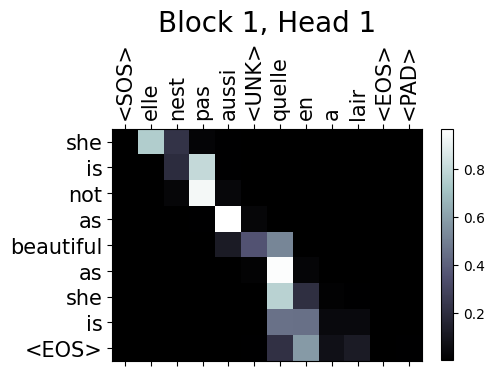

In [197]:
src_sent = src_tok.untokenize(
    X[ix].detach().tolist(), remove_padding_tokens=False
).split()
plot_attention(
    sentence=src_sent,
    translation=translation,
    attention=attn,
)

In [199]:
Xte = torch.tensor([]).type(torch.long).to(device)
Yte = torch.tensor([]).to(device)
for data in test_dl:
    Xte = torch.cat((Xte, data[0]), dim=0)
    Yte = torch.cat((Yte, data[1]), dim=0)
Xte.shape, Yte.shape

(torch.Size([332, 12]), torch.Size([332, 12]))

In [203]:
translations = [
    translate_sentence(
        src,
        model,
        src_tok,
        tgt_tok,
        device,
        max_output_length=tgt_tok.max_length,
    )[0]
    for src in tqdm(Xte)
]

  0%|          | 0/332 [00:00<?, ?it/s]

In [204]:
preds = [" ".join(t.split()[1:-1]) for t in translations]
targets = [[" ".join(tgt_tok.untokenize(t.tolist()).split()[1:-1])] for t in Yte]

In [205]:
ix = 0
preds[0], targets[0]

('we are what we <UNK>', ['you are what you eat'])

In [206]:
bleu = evaluate.load("bleu")

In [207]:
results = bleu.compute(
    predictions=preds, references=targets, tokenizer=lambda x: x.split()
)
results

{'bleu': 0.41070473412988756,
 'precisions': [0.7282549972987574,
  0.5358788676761027,
  0.34456613310867734,
  0.24561403508771928],
 'brevity_penalty': 0.9634090919359607,
 'length_ratio': 0.9640625,
 'translation_length': 1851,
 'reference_length': 1920}